In [499]:
import torch
import chirho.contrib.experiments.closed_form as cfe
import pyro.distributions as dist
from torch import tensor as tnsr
from torch import Tensor as Tnsr
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import numpy as np
from scipy.optimize import minimize

In [500]:
class CostRiskProblem:
    Sigma: Tnsr
    Q: Tnsr
    theta0: Tnsr
    c: Tnsr
    rstar: Tnsr
    theta0_init_dist: Tnsr

    @property
    def n(self):
        return self.Sigma.shape[0]

    def ana_loss(self, theta):
        return -cfe.full_ana_obj(theta=theta, Sigma=self.Sigma, Q=self.Q, c=self.c)

    def ana_loss_grad(self, theta):
        theta = theta.detach().requires_grad_(True)
        loss = self.ana_loss(theta)
        grad = torch.autograd.grad(loss, theta)[0]
        return grad


In [501]:
def generate_problem(q: float, n: int, rstar: float, theta0_rstar_delta: float) -> CostRiskProblem:
    """
    Generate a cost/risk minimization problem. Cost, in this case is simply ||theta||**2, while the risk
     is the expecation of the risk curve with respect to the distribution p(z) = N(0, Sigma).
    The risk curve is an unnormalized Gaussian with mean theta and covariance Q, which will have a covariance
     inducing a similar-sized curve to one with an I*q covariance.

    :param q: The stdev of the risk curve.
    :param n: The dimensionality of the problem.
    :param rstar: The distance to which theta should converge to solve the problem. This allows for precise experimental
     control over how far into the tails of p(z) the optimization should position the risk curve.
    :param theta0_rstar_delta: The delta from rstar that theta should be (randomly) initialized to. This will initialize
     theta to sit on a hypersphere of radius rstar + theta0_rstar_delta.
    :return:
    """

    q, rstar, theta0_rstar_delta = map(lambda x: tnsr(x) if not isinstance(x, Tnsr) else x, [q, rstar, theta0_rstar_delta])

    Sigma = dist.Wishart(covariance_matrix=torch.eye(n), df=tnsr(n+3)).sample()
    if torch.linalg.det(Sigma) <= 0.7:  # If too singular, try again recursively.
        return generate_problem(q, n, rstar, theta0_rstar_delta)
    Sigma = cfe.rescale_cov_to_unit_mass(Sigma)

    Q = dist.Wishart(covariance_matrix=torch.eye(n), df=tnsr(n+3)).sample()
    if torch.linalg.det(Q) <= 0.5:
        return generate_problem(q, n, rstar, theta0_rstar_delta)
    Q = cfe.rescale_cov_to_unit_mass(Q) * q

    c = cfe.compute_ana_c(q, rstar, n)

    # Generate a uniformly random direction on the unit hypersphere.
    theta0 = dist.Normal(torch.zeros(n), torch.ones(n)).sample()
    # Rescale to the desired radius.
    theta0 = theta0 / theta0.norm() * (rstar + theta0_rstar_delta)
    # And transform according to Sigma. This ensures that the initial theta does indeed sit on the rstar + theta0_rstar_delta
    #  contour of p(z), as opposed to just the unit normal.
    theta0 = torch.linalg.cholesky(Sigma) @ theta0

    problem = CostRiskProblem()
    problem.Sigma = Sigma.double()
    problem.Q = Q.double()
    problem.theta0 = theta0.double()
    problem.c = c.double()
    problem.rstar = rstar.double()
    problem.theta0_init_dist = (theta0_rstar_delta + rstar).double()

    # Gradcheck the problem's analytical loss.
    theta0 = problem.theta0.detach().requires_grad_(True)
    torch.autograd.gradcheck(problem.ana_loss, theta0)

    return problem

In [502]:
def solve_ana_with_scipy(problem: CostRiskProblem):
    traj = [problem.theta0.detach().numpy()]

    def callback(xk):
        traj.append(xk)

    def numpy_loss(theta: np.ndarray):
        return problem.ana_loss(tnsr(theta).double()).numpy()

    def numpy_grad(theta: np.ndarray):
        return problem.ana_loss_grad(tnsr(theta).double()).numpy()

    theta0 = problem.theta0.numpy()
    res = minimize(numpy_loss, theta0, method='BFGS', callback=callback, jac=numpy_grad)

    assert np.allclose(traj[-1], res.x)

    return traj

In [503]:
def get_ellipse_from_std_and_cov(std, cov):
    t = np.linspace(0, 2 * np.pi)
    circle = np.array([np.cos(t), np.sin(t)])
    ellipse = std * np.linalg.cholesky(cov) @ circle
    return ellipse


def visualize_problem(problem: CostRiskProblem, ax: plt.Axes):

    assert problem.n == 2, "Visualization only supported for 2D problems."

    xl = yl = 9

    # Set lims.
    ax.set_xlim(-xl, xl)
    ax.set_ylim(-yl, yl)

    ax.axhline(0, color='black', linewidth=0.1)
    ax.axvline(0, color='black', linewidth=0.1)

    # Define a grid for plotting
    x, y = np.mgrid[-xl:yl:.01, -xl:yl:.01]
    pos = np.dstack((x, y))

    prob_of_z = multivariate_normal(mean=[0, 0], cov=problem.Sigma).pdf(pos)

    risk_curve = cfe.risk_curve(
        theta=problem.theta0[None, None, :],
        Q=problem.Q[None, None, :, :],
        z=tnsr(pos).double()[:, :, None]).numpy().squeeze()

    # Plot the non-filled contours of the risk_curve.
    ax.contour(x, y, risk_curve, cmap='Reds', linewidths=0.5)
    ax.plot([], [], 'r-', label='risk')

    # Plot the rescaled covariance matrix
    ax.contourf(x, y, prob_of_z, cmap='Blues', alpha=0.9)
    ax.plot([], [], 'b-', label='p(z)')

    ax.set_aspect('equal', 'box')
    ax.set_title(f'Problem')

    # Plot ellipse by making a unit circle with radius rstar and then transforming it by Sigma.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.rstar, cov=problem.Sigma), '--', color='darkorange', linewidth=0.5, label='~r*')

    # And also plot the ellipse of the initial theta contour.
    ax.plot(*get_ellipse_from_std_and_cov(std=problem.theta0_init_dist, cov=problem.Sigma), '--', color='black', linewidth=0.3, label='r0')

    # Solve the analytic problem with scipy, and plot the trajectory.
    traj = solve_ana_with_scipy(problem)
    traj = np.array(traj)
    ax.plot(traj[:, 0], traj[:, 1], 'k-', linewidth=0.5, label='opt traj')

    # Plot the gradient vector field of the analytical loss.
    xl = yl = 5
    x, y = np.mgrid[-xl:yl:.4, -xl:yl:.4]
    pos = np.dstack((x, y))
    grad_field = np.array([-problem.ana_loss_grad(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(pos.shape)
    with np.errstate(divide='ignore', invalid='ignore'):  # Ignore div by zero warning.
        normed_grad_field = grad_field / np.linalg.norm(grad_field, axis=-1, keepdims=True)

    # Now, color the arrows according to the analytic objective (the negative of the loss).
    objvals = np.array([-problem.ana_loss(tnsr(p).double()).numpy() for p in pos.reshape(-1, 2)]).reshape(pos.shape[:-1])

    # Thin arrows.
    ax.quiver(x, y, normed_grad_field[:, :, 0], normed_grad_field[:, :, 1], objvals, cmap='cool',
              alpha=1., scale=80, width=0.0015, headwidth=3, headlength=4, pivot='mid')

    ax.legend(fontsize=6)

    # Remove axis ticks.
    ax.set_xticks([])
    ax.set_yticks([])

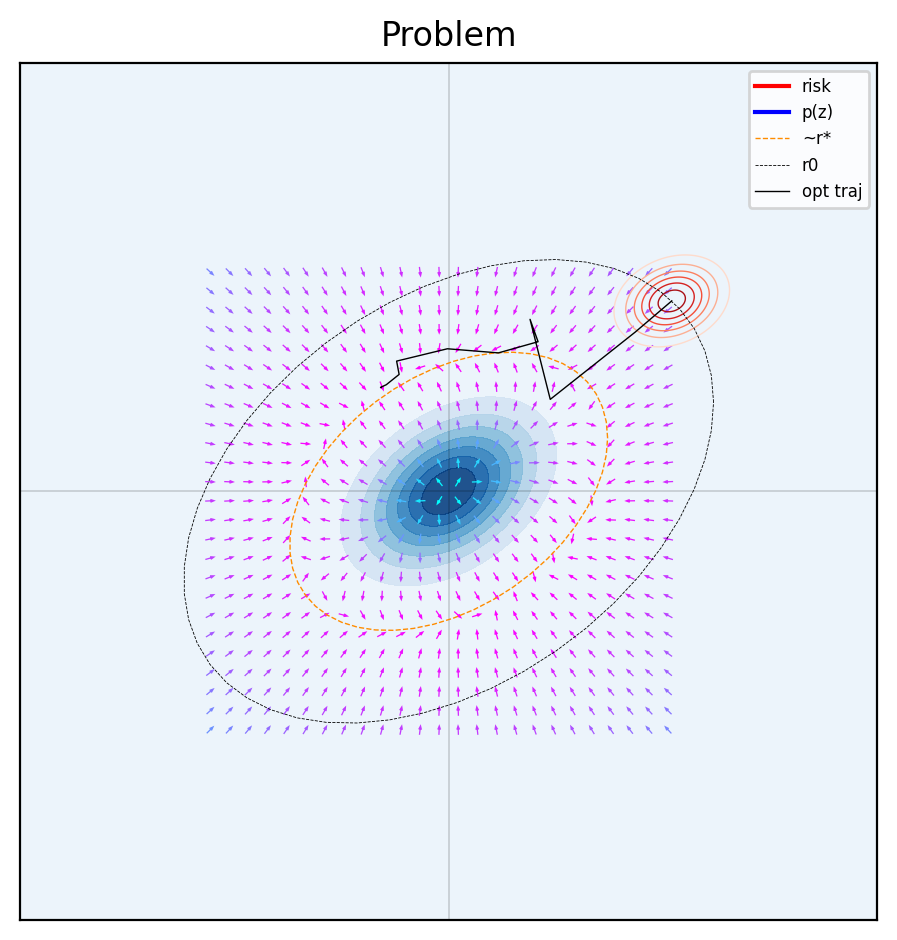

In [504]:
def example_problems():
    problem = generate_problem(q=0.3, n=2, rstar=3., theta0_rstar_delta=2.)
    fig, ax = plt.subplots(1, 1, dpi=200)
    visualize_problem(problem, ax)
    plt.tight_layout()
    plt.show()
example_problems()